In [1]:
import matplotlib.pyplot as plt

In [2]:
import numpy as np

In [3]:
%matplotlib inline

In [4]:
from qkit.analysis.circle_fit.circuit import reflection_singleport as rf_p
from qkit.analysis.circle_fit.circuit import reflection_port as rf

In [5]:
import matplotlib.colors as col
import matplotlib.cm as cm

In [6]:
    def _set_data_range(freq,data, f_min, f_max):
        '''
        cuts the data array to the positions where f>=f_min and f<=f_max in the frequency-array
        the fit functions are fitted only in this area
        the data in the .h5-file is NOT changed
        '''
        if data.ndim == 1:
            return data[(freq >= f_min) & (freq <= f_max)]
        if data.ndim == 2:
            ret_array=np.empty(shape=(data.shape[0],freq.shape[0]),dtype=np.float64)
            for i,a in enumerate(data):
                ret_array[i]=data[i][(freq >= f_min) & (freq <= f_max)]
            return ret_array
            
    def _prepare_f_range(freq,f_min,f_max, array):
        '''
        prepares the data to be fitted:
        f_min (float): lower boundary
        f_max (float): upper boundary
        '''

        ff_min = np.min(freq)
        ff_max = np.max(freq)

        '''
        f_min f_max do not have to be exactly an entry in the freq-array
        '''
        if f_min:
            for freq_1 in freq:
                if freq_1 > f_min:
                    ff_min = freq_1
                    break
        if f_max:
            for freq_1 in freq:
                if freq_1 > f_max:
                    ff_max = freq_1
                    break
                    
        return np.array(_set_data_range(freq,array, ff_min, ff_max))


In [7]:
def array_cutter(thres,arr):
    mask = []
    arr_cut = []
    for c in range(len(arr)):
        mask.append(np.any(arr[c] > thres, axis = 0))
    for c in range(len(mask)):
        if np.ma.masked_array(arr,mask)[c]:
            arr_cut.append(arr[c])
            
    return arr_cut
    

In [8]:
def mask(thres,arr):
    mask = []
    for c in range(len(arr)):
        mask.append(np.any(arr[c] > thres, axis = 0))
    return mask

In [9]:
def data_mask(tolerance = 1):   #creates data mask             #.T creates the transpose of the matrix/array which makes it  
    m = m_dat.T                                                #quite convenient to seperate different entries by sequence unpacking 
    mask_a = []
    #print m[0]
    for c in range(m.shape[0]):                             #m.shape[0]: number of entries in the oth row (= oth column of m_dat) m.shape[0]= len(x_val) = 15
                                                            #m[c] is the cth row of m
        lower_th = np.mean(m[c]) - tolerance*np.abs(np.mean(m[c]))      #lower threshold
        #print lower_th                 #lower_th = 0.0
        upper_th = np.mean(m[c]) + tolerance*np.abs(np.mean(m[c]))      #upper threshold
        #print upper_th
        #print np.mean(m[c])
        #print np.any((m[c] < lower_th, m[c] > upper_th),axis=0)        #np.any tests if an element is True or False with respect to the conditions
        mask_a.append(np.any((m[c] < lower_th, m[c] > upper_th),axis=0))   #creates mask array, that contains the information about invalid values in m
    return np.array(mask_a).T                                              #axis = 0 means testing columnwise
                                                                           


#data_mask()


In [10]:
def normalize(m):   #normalize columnwise (c: column)
    for c in range(len(m[0])):                                   #m[0] contains all frequencies (m is transposed of m_dat)
        min_v = np.ma.min(np.ma.masked_array(m_dat, data_mask())[:,c])    #np.ma.masked_array: subclass to manipulate arrays with missing data
        m[:,c] = m[:,c] - min_v   # -> min. value of m[:,c] = 0               #ma.masked_array(array, mask), compares array to array-like mask
        max_v = np.ma.max(np.ma.masked_array(m_dat, data_mask())[:,c])    # and filles invalid entries with a specified value
        m[:,c] /= max_v    #normalize towards the max value in column c
    return m

In [11]:
stridat = "C:/Users/Patrick/Documents/JPA/Mask #2/data/20151218/161948_1D2_time/161948_1D2_time.dat"
data = np.genfromtxt(stridat).T   #genformtxt: Load data from a text file, with missing values handled as specified.

In [12]:
tempdat = "C:/Users/Patrick/Documents/JPA/Mask #2/data/20151218/161948_1D2_time/temp_time_log.dat"
tempdata = np.genfromtxt(tempdat).T 

In [13]:
tempdata.shape

(3, 2008)

In [14]:
'''temperature values; note: warm up until 1.5 K, followed by a rest and re-cooling to 1.3 K'''
T = tempdata[1]

In [15]:
print data.shape      #the L occures for large arrays

(4, 2008000)


In [16]:
row_x = 0
row_y = 1
row_d = 2    #= 6 before, changed to 2 (amplitude)

In [17]:
time = np.unique(np.array(data[row_x], dtype = np.float64))        #finds the unique elements of an array
len(time)                            #x_val contains all unique elements

2008

In [18]:
np.set_printoptions(threshold=np.inf)

In [19]:
x_val_cut = []

In [20]:
tmin = time[0]
tmax = time[68]

In [21]:
time_cut = []
time_cut = _prepare_f_range(time,tmin,tmax,time)

In [22]:
len(time_cut)

69

In [23]:
temp_cut = []
temp_cut = _prepare_f_range(time_cut, tmin, tmax, T)

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:8: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 2008 but corresponding boolean dimension is 69


In [24]:
tmax_index = np.where(time_cut == time_cut[np.argmax(temp_cut)])[0][0]

In [25]:
tmax_index

68

In [26]:
freq = np.extract(data[row_x] == data[row_x][0],data[row_y])     #first argument: condition, second argument: array
len(freq)                                                        #y_val contains all frequencies. 1000 entries



1000

In [67]:
fmin = 8.80e9
fmax = 9.00e9
#fmax = freq[-1]

In [68]:
fit_freq = _prepare_f_range(freq, fmin, fmax, freq)

In [69]:
fit_freq.shape

(100,)

In [70]:
amp_val = []
phase_val = []

In [71]:
for c in range(len(time_cut)):
    amp_val.append(np.extract(data[row_x] == data[row_x][1000*c],data[row_d]))
    phase_val.append(np.extract(data[row_x] == data[row_x][1000*c],data[3]))

In [72]:
np.array(amp_val).shape

(69, 1000)

In [73]:
amp_cut = _prepare_f_range(fit_freq, fmin, fmax, np.array(amp_val))
phase_cut = _prepare_f_range(fit_freq, fmin, fmax, np.array(phase_val))

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:12: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 1000 but corresponding boolean dimension is 100


In [74]:
print amp_cut.shape
print phase_cut.shape

(69, 100)
(69, 100)


In [75]:
phase_cut[0].shape

(100,)

In [76]:
test = np.unwrap(phase_cut.T)

In [77]:


#m_dat_n = normalize(m = m_dat)


In [78]:
test.shape

(100, 69)

In [79]:
X, Y = np.meshgrid(time_cut, fit_freq)

In [80]:
startcolor        =   'black'
midcolor          =   'blue'
endcolor          =   'white'

#startcolor = 'blue'  # a dark olive 
#midcolor = 'white'    # a bright yellow
#endcolor = 'red'    # medium dark red
c_cmap = col.LinearSegmentedColormap.from_list('olive',[startcolor,midcolor,endcolor])
# extra arguments are N=256, gamma=1.0
cm.register_cmap(cmap=c_cmap)



In [81]:
amp_cut.shape

(69, 100)

In [82]:
font = {'weight' : 'normal', 'size' : 20}
plt.rc('font', **font)
labelsize=27

In [83]:
z_data_raw = amp_cut*np.exp(1.j*(phase_cut+np.pi))

In [84]:
cf = rf_p(fit_freq, z_data_raw[0])

In [85]:
cf.set_theta0(0)

In [86]:
cf.set_slope(None)

In [87]:
cf.set_Ql(500)

In [88]:
cf.set_deriv(2, 200)

In [89]:
#cf.get_delay(fit_freq, z_data_raw[0], 'overcoupled', plot = True)

In [90]:
#cf.autofit('overcoupled')

In [91]:
#cf.plot_all()

In [92]:
'''circle fit routine for every power value
fres_cal = []
fres_pf = []
chi_sqr = []
Qloaded = []
Qload_pf = []
z_data_sim = []
for i in range(len(time_cut)):
    #powerspec._get_data_circle(norm = False)
    cf = rf_p(fit_freq, z_data_raw[i])
    cf.set_Ql(500)
    cf.set_theta0(0)
    cf.set_slope(None)
    cf.set_deriv(2, 200)
    cf.autofit(coupling = 'overcoupled', ignoreslope = False, refine_res = True, plot = False)
    z_data_sim.append(cf.z_data_sim)
    fitresults = cf.fitresults
    fres_cal.append(fitresults['fr'])
    chi_sqr.append(fitresults['chi_square'])
    Qloaded.append(fitresults['Ql'])
    _fr, sign = cf._phase_fr_sign(fit_freq, np.unwrap(np.angle(z_data_raw[i])),2, 200)
    theta0, Ql, fr , slope = cf._phase_fit_wslope(fit_freq, z_data_raw[i], 0, 500, _fr, None, 1.)
    Qload_pf.append(Ql)
    fres_pf.append(fr)
'''

"circle fit routine for every power value\nfres_cal = []\nfres_pf = []\nchi_sqr = []\nQloaded = []\nQload_pf = []\nz_data_sim = []\nfor i in range(len(time_cut)):\n    #powerspec._get_data_circle(norm = False)\n    cf = rf_p(fit_freq, z_data_raw[i])\n    cf.set_Ql(500)\n    cf.set_theta0(0)\n    cf.set_slope(None)\n    cf.set_deriv(2, 200)\n    cf.autofit(coupling = 'overcoupled', ignoreslope = False, refine_res = True, plot = False)\n    z_data_sim.append(cf.z_data_sim)\n    fitresults = cf.fitresults\n    fres_cal.append(fitresults['fr'])\n    chi_sqr.append(fitresults['chi_square'])\n    Qloaded.append(fitresults['Ql'])\n    _fr, sign = cf._phase_fr_sign(fit_freq, np.unwrap(np.angle(z_data_raw[i])),2, 200)\n    theta0, Ql, fr , slope = cf._phase_fit_wslope(fit_freq, z_data_raw[i], 0, 500, _fr, None, 1.)\n    Qload_pf.append(Ql)\n    fres_pf.append(fr)\n"

In [93]:
fr = []
for c in range(len(time_cut)):
    fr.append(fit_freq[np.argmin(amp_cut[c])])

In [94]:
fr = np.array(fr)
fres_mask = []
mask = []
for i in range(len(fr)):
    low = 8.8e9
    high = 8.865e9
    mask.append(np.any((fr[i] > high, fr[i] < low), axis = 0))
fres_mask = np.ma.masked_array(fr,mask)

In [95]:
fres_mask

masked_array(data = [8860060060.06 8860060060.06 8860060060.06 8860060060.06 8860060060.06
 8860060060.06 8860060060.06 8860060060.06 8860060060.06 8860060060.06
 8860060060.06 8860060060.06 8860060060.06 8860060060.06 8860060060.06
 8860060060.06 8860060060.06 8860060060.06 8860060060.06 8860060060.06
 8860060060.06 8860060060.06 8860060060.06 8860060060.06 8860060060.06
 8860060060.06 8860060060.06 8860060060.06 8860060060.06 8860060060.06
 8860060060.06 8860060060.06 8860060060.06 8860060060.06 8860060060.06
 8860060060.06 8860060060.06 8860060060.06 8860060060.06 8860060060.06
 8860060060.06 8860060060.06 8860060060.06 8860060060.06 8860060060.06
 8860060060.06 8860060060.06 8860060060.06 8860060060.06 8860060060.06
 8860060060.06 8852052052.052 8846046046.046 8836036036.036 8820020020.02
 8802002002.002 -- -- -- -- -- -- -- -- -- -- -- -- --],
             mask = [False False False False False False False False False False False False
 False False False False False False False Fal

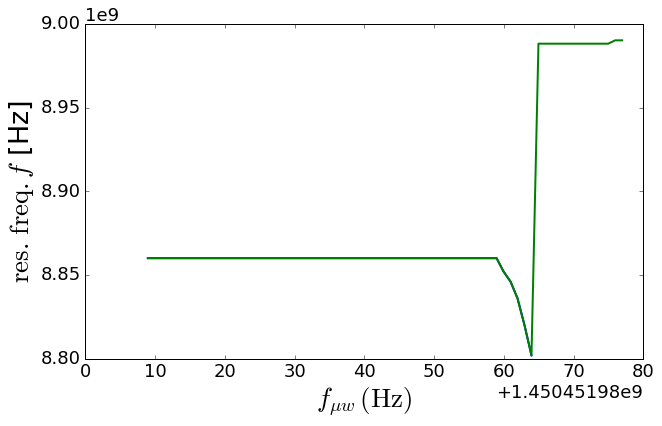

In [96]:
fig, axes = plt.subplots(figsize = (10,6))
axes.plot(time_cut,fres_mask, label = 'fres (circle fit)', lw = 2, color = 'blue')
axes.plot(time_cut,fr, label = 'fres (circle fit)', lw = 2, color = 'green')
#axes.plot(time_cut,fres_cal, label = 'fres (phase fit)', lw = 2, color = 'green')
axes.set_ylabel(r'$\mathrm{res.\,freq.} f$ [Hz]', fontsize = labelsize)
axes.set_xlabel(r'$f_{\mu w}\,(\mathrm{Hz})$', fontsize= labelsize)

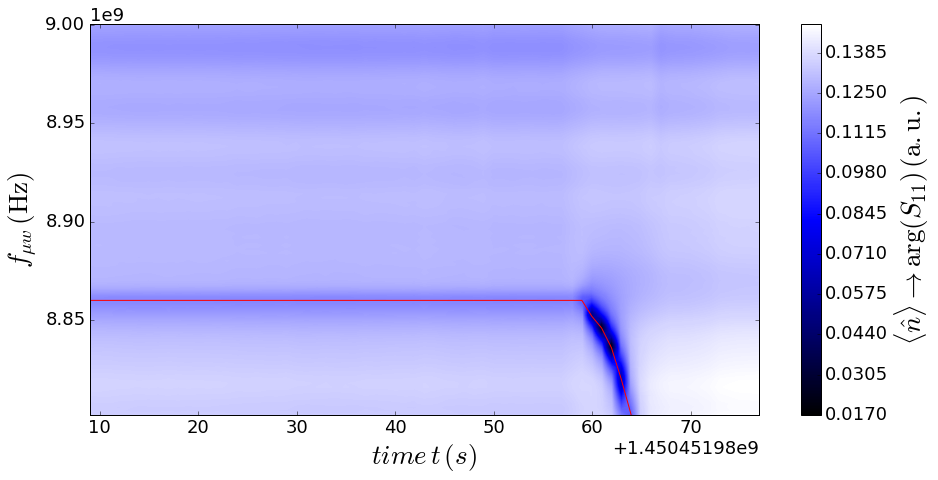

In [97]:
fig, axes = plt.subplots(figsize=(15,7))
#p = axes.pcolor(X, Y, np.ma.masked_array(m_dat_n, data_mask()), cmap=c_cmap)
p = axes.contourf(X, Y, amp_cut.T, 300, cmap=c_cmap)
cb = fig.colorbar(p, ax=axes)
axes.plot(time_cut, fres_mask, color = 'red')
cb.set_label(r'$\langle\hat n\rangle \rightarrow \arg (S_{11})\,\mathrm{(a.u.)}$', fontsize=labelsize)
#p.set_clim(0.7,1)
#axes.set_xlim(x_val[0], 1.4504519*10**9+250)
#axes.set_ylim(y_val[0], y_val[-1])
axes.set_xlabel(r'$time\,t\,(s)$', fontsize=labelsize)
axes.set_ylabel(r'$f_{\mu w}\,(\mathrm{Hz})$', fontsize=labelsize)
#fig.tight_layout()

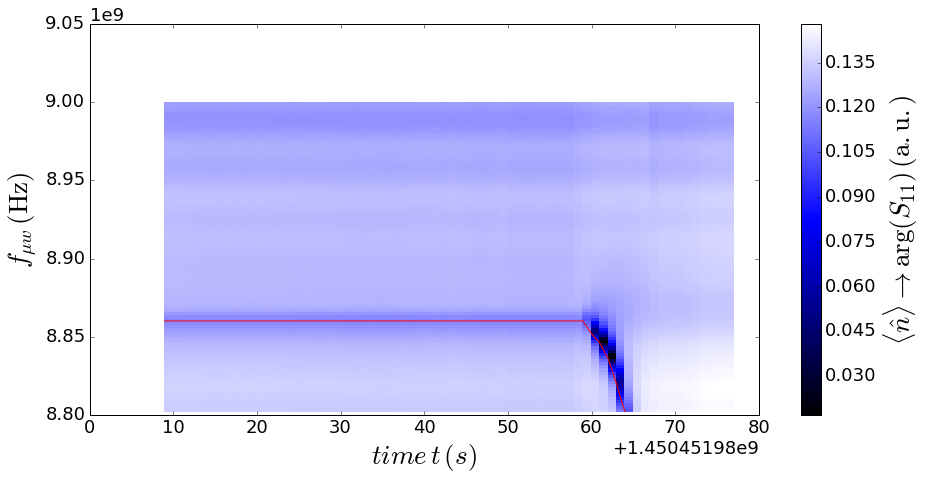

In [98]:
fig, axes = plt.subplots(figsize=(15,7))
#p = axes.pcolor(X, Y, np.ma.masked_array(m_dat_n, data_mask()), cmap=c_cmap)
p = axes.pcolor(X, Y, amp_cut.T, cmap=c_cmap)
axes.plot(time_cut, fres_mask, color = 'red')
cb = fig.colorbar(p, ax=axes)
cb.set_label(r'$\langle\hat n\rangle \rightarrow \arg (S_{11})\,\mathrm{(a.u.)}$', fontsize=labelsize)
#p.set_clim(0.7,1)
#axes.set_xlim(x_val[0], 1.4504519*10**9+250)
#axes.set_ylim(y_val[0], y_val[-1])
axes.set_xlabel(r'$time\,t\,(s)$', fontsize=labelsize)
axes.set_ylabel(r'$f_{\mu w}\,(\mathrm{Hz})$', fontsize=labelsize)
#fig.tight_layout()

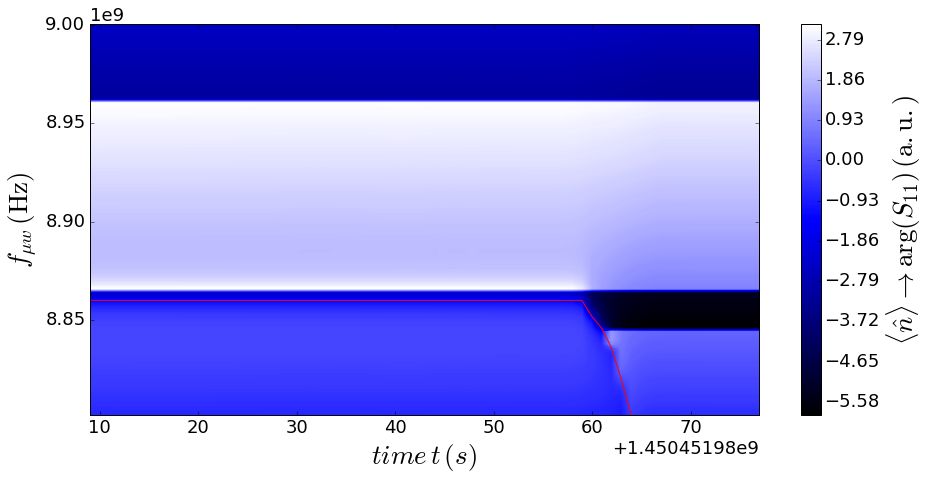

In [99]:
fig, axes = plt.subplots(figsize=(15,7))
#p = axes.pcolor(X, Y, np.ma.masked_array(m_dat_n, data_mask()), cmap=c_cmap)
p = axes.contourf(X, Y, test, 300, cmap=c_cmap)
cb = fig.colorbar(p, ax=axes)
axes.plot(time_cut, fres_mask, color = 'red')
cb.set_label(r'$\langle\hat n\rangle \rightarrow \arg (S_{11})\,\mathrm{(a.u.)}$', fontsize=labelsize)
#p.set_clim(0.7,1)
#axes.set_xlim(x_val[0], 1.4504519*10**9+250)
#axes.set_ylim(y_val[0], y_val[-1])
axes.set_xlabel(r'$time\,t\,(s)$', fontsize=labelsize)
axes.set_ylabel(r'$f_{\mu w}\,(\mathrm{Hz})$', fontsize=labelsize)
#fig.tight_layout()

In [100]:
X1, Y1 = np.meshgrid(temp_cut, fit_freq)

In [115]:
amp_max = np.max(amp_cut)

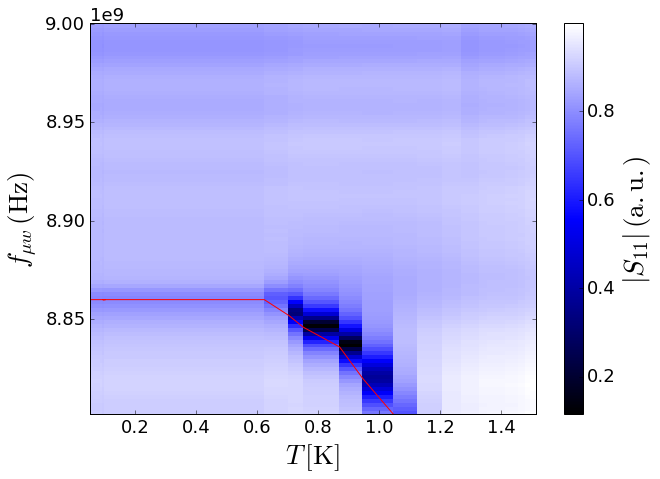

In [129]:
fig, axes = plt.subplots(figsize=(10,7))
#p = axes.pcolor(X, Y, np.ma.masked_array(m_dat_n, data_mask()), cmap=c_cmap)
p = axes.pcolor(X1, Y1, amp_cut.T/amp_max, cmap=c_cmap) 
cb = fig.colorbar(p, ax=axes)
axes.plot(temp_cut, fres_mask, color = 'red')
cb.set_label(r'$|S_{11}|\,\mathrm{(a.u.)}$', fontsize=labelsize)
#p.set_clim(0.7,1)
axes.set_xlim(temp_cut[0], temp_cut[-1])
axes.set_ylim(fit_freq[0], fit_freq[-1])
cb.set_ticks([0.2,0.4,0.6,0.8,1.0])
axes.set_xlabel(r'$T\,[\mathrm{K}]$', fontsize=labelsize)
axes.set_ylabel(r'$f_{\mu w}\,(\mathrm{Hz})$', fontsize=labelsize)
#fig.tight_layout()

In [130]:
fig.savefig('temp_scan.pdf', dpi = 100, bbox_inches = 'tight')

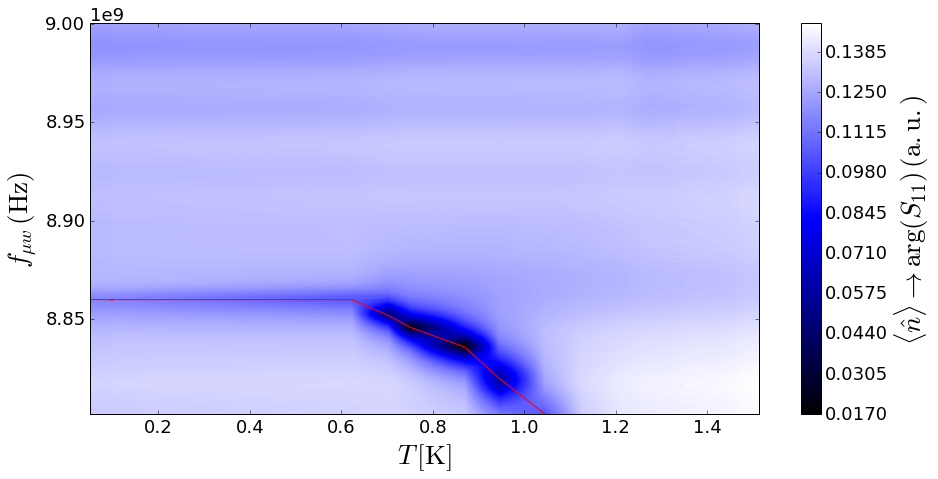

In [103]:
fig, axes = plt.subplots(figsize=(15,7))
#p = axes.pcolor(X, Y, np.ma.masked_array(m_dat_n, data_mask()), cmap=c_cmap)
p = axes.contourf(X1, Y1, amp_cut.T, 300,  cmap=c_cmap)
cb = fig.colorbar(p, ax=axes)
axes.plot(temp_cut, fres_mask, color = 'red')
cb.set_label(r'$\langle\hat n\rangle \rightarrow \arg (S_{11})\,\mathrm{(a.u.)}$', fontsize=labelsize)
#p.set_clim(0.7,1)
axes.set_xlim(temp_cut[0], temp_cut[-1])
axes.set_ylim(fit_freq[0], fit_freq[-1])
axes.set_xlabel(r'$T\,[\mathrm{K}]$', fontsize=labelsize)
axes.set_ylabel(r'$f_{\mu w}\,(\mathrm{Hz})$', fontsize=labelsize)
#fig.tight_layout()


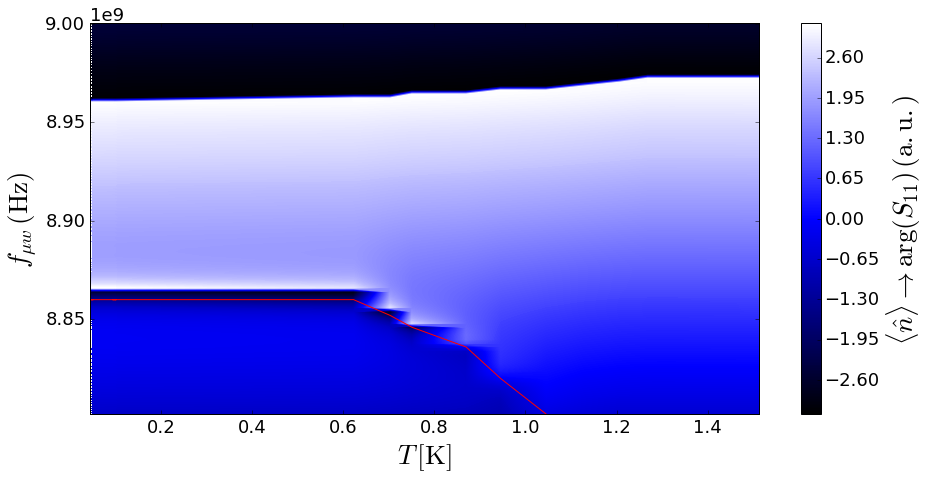

In [104]:
fig, axes = plt.subplots(figsize=(15,7))
#p = axes.pcolor(X, Y, np.ma.masked_array(m_dat_n, data_mask()), cmap=c_cmap)
p = axes.contourf(X1, Y1, phase_cut.T, 300, cmap=c_cmap)
cb = fig.colorbar(p, ax=axes)
axes.plot(temp_cut, fres_mask, color = 'red')
cb.set_label(r'$\langle\hat n\rangle \rightarrow \arg (S_{11})\,\mathrm{(a.u.)}$', fontsize=labelsize)
#p.set_clim(0.7,1)
#axes.set_xlim(x_val[0], 1.4504519*10**9+250)
#axes.set_ylim(y_val[0], y_val[-1])
axes.set_xlabel(r'$T\,[\mathrm{K}]$', fontsize=labelsize)
axes.set_ylabel(r'$f_{\mu w}\,(\mathrm{Hz})$', fontsize=labelsize)
#fig.tight_layout()

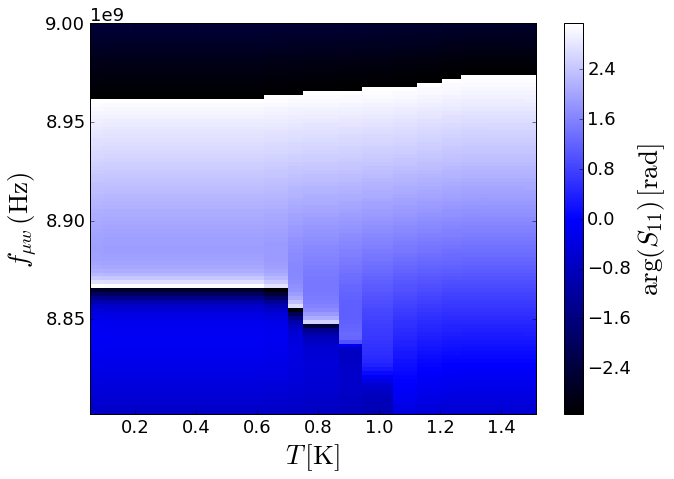

In [110]:
fig, axes = plt.subplots(figsize=(10,7))
#p = axes.pcolor(X, Y, np.ma.masked_array(m_dat_n, data_mask()), cmap=c_cmap)
p = axes.pcolor(X1, Y1, phase_cut.T, cmap=c_cmap)
cb = fig.colorbar(p, ax=axes)
cb.set_label(r'$\arg (S_{11})\,\mathrm{[rad]}$', fontsize=labelsize)
axes.set_xlim(temp_cut[0], temp_cut[-1])
axes.set_ylim(fit_freq[0], fit_freq[-1])
axes.set_xlabel(r'$T\,[\mathrm{K}]$', fontsize=labelsize)
axes.set_ylabel(r'$f_{\mu w}\,(\mathrm{Hz})$', fontsize=labelsize)
#fig.tight_layout()

In [111]:
fig.savefig('temp_scan_phase.pdf', dpi = 100, bbox_inches = 'tight')